# Giving markov chains a try

In [216]:
import json
import csv
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import geopandas as gpd
import shapely
from shapely.geometry import Point, MultiPoint, Polygon, MultiPolygon
from shapely.affinity import scale
import matplotlib.pyplot as plt

import glob
import os
import datetime

In [203]:
df = pd.read_csv('FinalData/df_AS_price_vol.csv')

In [204]:
data = np.array(df.loc[:8760,'price_DAH_Down Regulation'])

From https://github.com/aaronkandel/Markov-Chain-Modeling/blob/master/markovChainFunction.m

In [205]:
def MarkovChainFunction(data, bins):
    """ Data should be numpy array; bins is an integer """
    
    #Normalize data
    datMin = min(data)
    datMax = max(data)
    datNorm = (data - datMin)/(datMax - datMin)
    
    # Create Markov Transition Table:
    mesh = np.linspace(0, 1, bins)
    meshReal = (mesh*(datMax - datMin) + datMin)
    dmesh = mesh[1] - mesh[0]
    dmeshReal = meshReal[1] - meshReal[0]
    
    markovArray = np.zeros((len(mesh), len(mesh)))
    cumMarkovArray = np.zeros((len(mesh), len(mesh)))
    
    # Populate Markov Transition Table:
    for i in range(1,(len(data)-1)):
        datNow = datNorm[i]
        datBefore = datNorm[i-1]

        dn = np.floor(datNow / dmesh) # Get index....TODO: DO WE NOT WANT TO ROUND DOWN**? Ask Aaron
        db = np.floor(datBefore / dmesh) # Get index

        markovArray[int(db), int(dn)] = markovArray[int(db), int(dn)] + 1;  #Update MTT
    
    # Transform data in transition table to probability:
    markovArray = markovArray/np.sum(markovArray, axis=1, keepdims = True) #? from https://stackoverflow.com/questions/16202348/numpy-divide-row-by-row-sum  
    cumMarkovArray = np.cumsum(markovArray, axis=1)
    
    # Eliminate potential NaNs from potential /0:
    ind = np.isnan(markovArray)
    markovArray[ind] = 0
    cumMarkovArray[ind] = 0
    
    return markovArray, cumMarkovArray, datMin, datMax

In [206]:
markovArray, cumMarkovArray, datMin, datMax = MarkovChainFunction(data, 20)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


In [207]:
def MarkovSim(data, cumMarkovArray, datMin, datMax):
    #Simluate Markov Chain Model
    datSim = np.zeros_like(data)
    datSim[0] = 1 # Set same initial condition

    np.random.seed(1)
    rands = np.random.random_sample(len(data))

    for i in range(len(data)-1): #length(data)

        # Find current row on MTT:
        curState = int(datSim[i])

        # Create random transition:
        r = rands[i]
        check = np.where(cumMarkovArray[curState, :] > r)

        # Transition to next state:
        nextState = check[0][0]
        datSim[i+1] = nextState

    # Un-Normalize Simulated Data:
    datSim = datSim/max(datSim)
    datSim = datSim*(datMax - datMin) + datMin
    
    return datSim

In [208]:
datSim = MarkovSim(data, cumMarkovArray, datMin, datMax)

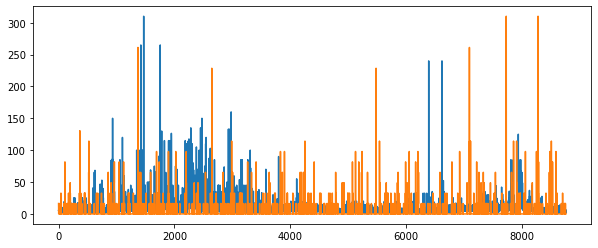

In [209]:
fig = plt.figure(figsize=(10,4))
plt.plot(data)
plt.plot(datSim)

In [210]:
from sklearn.metrics import mean_squared_error
mean_squared_error(data,datSim) #quite high for full year. what if we go month by month?
#could also somehow use randomness and not set seed...
#should also tell Aaron you found a bug--floor

382.01291174523453

## Trying Markov chain model month by month

month 0 MSE 93.33781290528314
month 1 MSE 1636.9164219140082
month 2 MSE 1279.6124144989453
month 3 MSE 847.5735090951702
month 4 MSE 514.5037772538142
month 5 MSE 65.97050789223954
month 6 MSE 23.024111492092672
month 7 MSE 24.13557871492733
month 8 MSE 865.5329463245492
month 9 MSE 1136.940638696255
month 10 MSE 132.9826158398039
month 11 MSE 248.44197626027253


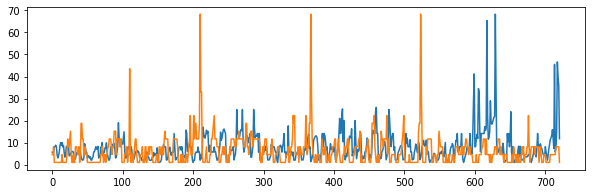

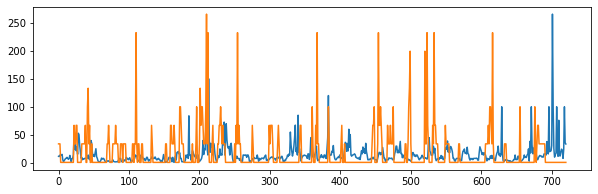

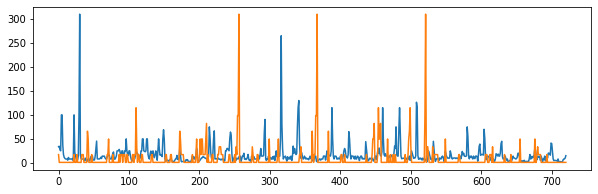

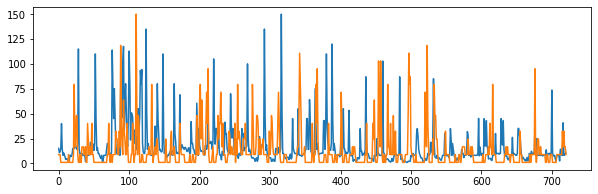

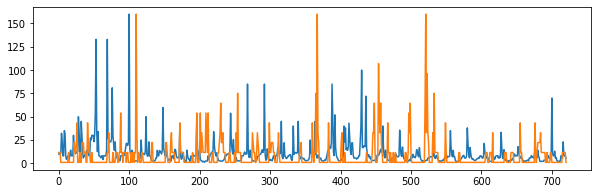

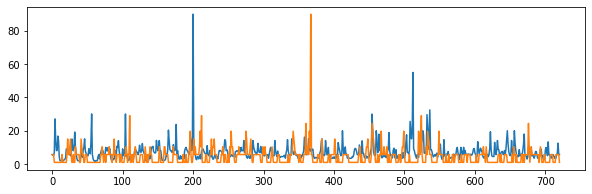

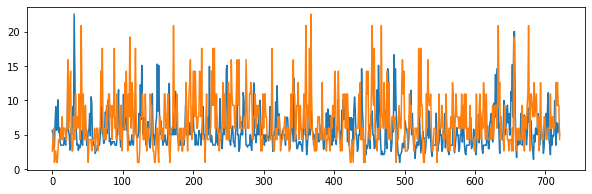

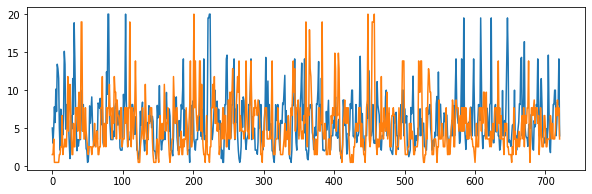

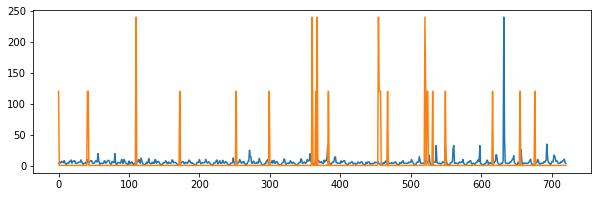

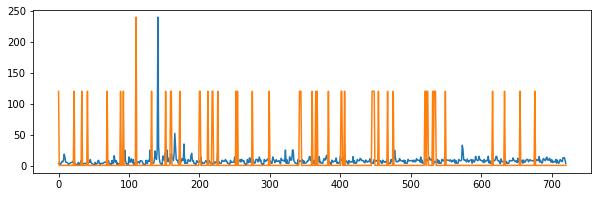

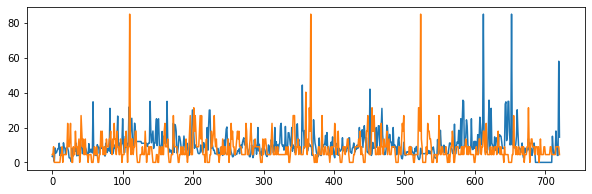

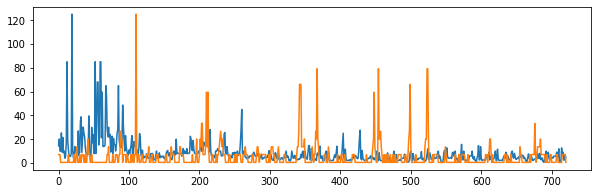

In [217]:
hrs = 30*24
for month in range(12):
    
    data = df.loc[month*hrs:(month+1)*hrs,'price_DAH_Down Regulation']
    data = np.array(data)
    
    markovArray, cumMarkovArray, datMin, datMax = MarkovChainFunction(data, 20)
    datSim = MarkovSim(data, cumMarkovArray, datMin, datMax)
    mse = mean_squared_error(data,datSim)
    
    print("month " + str(month) + " MSE " + str(mse))
    fig = plt.figure(figsize=(10,3))
    plt.plot(data)
    plt.plot(datSim)

OK, clearly we need something hour-to-hour to get the spikes to happen at the right hours of the day. Let's try: